# RL: Part 2: Agents That Act in an Environment


Here we are going to implement a RL agent interacting with a simple environment. In this case, our agent would be a simulated RL mouse, and the environment a 2D maze.

## Defining the Environment

To define the environment, we need to define the set of possible states $S = {s_1, s_2 ... s_N}$, the transition function $P_{s,s'}^{a}$, and the reward transition function $R_{s,s'}^{a}$.

In our case, the environment just consists of a 4x4 grid. Our hypothetical agent perceives only one cell at any time---the cell where it is.  Therefore, our states correspond to the sixteen position of the maze, which we can indicate with the coordinates $(0, 0), (0, 1) ... (0, 3), (1, 0) ... (3, 3)$.

An environment is characterized by two functions:

* The state transition probability function $P(s, a, s')$, which the probability of transitioning to a possible state $s'$ when action $a$ is applied during state $s$; and

* The reward transition probability function $R(s, a, s')$, which is the probability of receiving a reward $r$ when action $a$ is applied to state $s$ and the environment moves to state $s'$.

In our simple cases, both $P(s,a,s')$ and $R(s,a,s')$ will be simplified to deterministic functions.

A run of the maze ends when the simulated "rat" agent finds the cheese reward. To simulate this fact, we will add a "termination" state, indicated as `None`. The transition function will automatically move the agent to a `None` state whatever action is taken after the cheese is found.


In [1]:
import random
import numpy as np
from copy import copy
import matplotlib.pyplot as plt 

class Maze():
    """A maze environment"""

    ACTIONS = ("up", "down", "left", "right") # List of actions
    INITIAL_STATE = (0, 0) # Always starts at the topleft corner
    
    def __init__(self, fname = "grid.txt"):
        """Inits a maze by loading the grid file"""
        self.grid = np.loadtxt(fname)
        self.state = self.INITIAL_STATE
        self.end = False


    def state_transition(self, state1, action1):
        "Defines the next state gien the "
        x, y = state1
        
        # If we have reached the cheese, we transition 
        # to the terminal state
        if self.grid[x, y] > 0:
            return None
        
        # Otherwise, we update the position
        state2 = copy(state1)
        
        if action1 in self.ACTIONS:
            if action1 == "up":
                if x > 0:
                    state2 = (x - 1, y)
            
            elif action1 == "left":
                if y > 0:
                    state2 = (x, y - 1)
            
            elif action1 == "down":
                if x < (self.grid.shape[0] - 1):
                    state2 = (x + 1, y)

            elif action1 == "right":
                if y < (self.grid.shape[1] - 1):
                    state2 = (x, y + 1)
                    
        return state2
                    
    
    def reward_transition(self, state1, action1, state2):
        """Reward is -1 for bouncing against the walls, and whatever is on the grid otherwise"""
        if state1 == state2:
            return -1
        elif state2 == None:
            return 0
        else:
            return self.grid[state2[0], state2[1]]
        
    
    # Quick way to combine State transitions and Reward transitions 
    def transition(self, action1):
        """Changes the state following an action"""
        state1 = self.state
        state2 = self.state_transition(state1, action1)
        reward2 = self.reward_transition(state1, action1, state2)
        
        self.state = state2
        return (state2, reward2) # Returns s_t+1, r_t+1

    
    def print_state(self):
        "Prints a text representation of the maze (with the agent position)"
        bar = "-" * ( 4 * self.grid.shape[1] + 1)
        for i in range(self.grid.shape[0]):
            row = "|"
            for j in range(self.grid.shape[1]):
                cell = " "
                if i == self.state[0] and j == self.state[1]:
                    cell = "*"
                row += (" %s |" % cell)
            print(bar)
            print(row)
        print(bar)

## Testing the maze
The maze is simple but functional. It is easy to create a maze, check the available actions, apply a few actions, and so on. Let's check that our environment works.

In [2]:
m = Maze()
m.print_state()
state_after_bad_action = m.state_transition(m.state, "up")  # Illigal action: bounces!
state_after_good_action = m.state_transition(m.state, "down") # Legal action: Goes down

print("State after illegal action: %s" % (state_after_bad_action,))
print("Reward after illegal action: %s" % (m.reward_transition(m.state, "up", state_after_bad_action)))

print("State after legal action: %s" % (state_after_good_action,))
print("Reward after legal action: %s" % (m.reward_transition(m.state, "down", state_after_good_action)))

-----------------
| * |   |   |   |
-----------------
|   |   |   |   |
-----------------
|   |   |   |   |
-----------------
|   |   |   |   |
-----------------
State after illegal action: (0, 0)
Reward after illegal action: -1
State after legal action: (1, 0)
Reward after legal action: 0.0


And, finally, we can easily navigate in our virtual maze by executing the appropriate actions:

In [3]:
m.transition("down")

((1, 0), 0.0)

Note how the ```Maze``` object returns two values at the end of each action execution, the new state $s_{t+1}$ and the associated reward $r_{t+1}$. If the ```down``` action was executed with the original maze layout of the ```grid.txt``` file, case, the two values are $s_{t+1} = $ ```(3, 0)``` and $r_{t+1} = $ ```0.0```. We can also execute more actions, and see what happens after a few movements:

In [4]:
m.transition("down")
m.transition("down")
m.transition("right")
m.print_state()

-----------------
|   |   |   |   |
-----------------
|   |   |   |   |
-----------------
|   |   |   |   |
-----------------
|   | * |   |   |
-----------------


## Creating a $V$-Agent

Now we can create our own very fantastic agents! As an example, we will create a $V$-learning agent that interacts with the ``` Maze``` world.

The agent contains two parts:

1. The agent's _memory_ is composed of a single $V$-table, which contains  $4 \times 4 = 16$ states, one for every possible position in the maze. 
2. The agent's _policy_ is a simple policy that selects actions _at random_. This guarantees that the agent will explore the environment 

In [5]:

class VAgent():
    """An agent that keeps track of the value of states"""
    def __init__(self, actions=Maze.ACTIONS, alpha=0.1, gamma=0.9):
        """Creates a V-agent"""
        self.V = {}                # Initial dictionary of (s, a) pairs. At the beginning, it's emtpy.
        self.alpha = alpha         # Learning rate
        self.gamma = gamma         # Temporal discounting
        self.actions = actions     # Set of possible actions (provide those of Maze.ACTIONS)


    def policy(self, state):
        """Random policy to explore the maze"""
        return random.choice(self.actions)
        
    
    def td_learning(self, state1, reward1, state2):
        """Updates the Q-values when given an (s,a) pair, the reward value and a new state"""
        g = self.gamma
        a = self.alpha
        
        v1 = 0.0
        
        if state1 in self.V.keys():
            v1 = self.V[state1]
        
        v2 = 0.0
        
        if state2 in self.V.keys():
            v2 = self.V[state2]
        
        rpe = reward1 + g * v2 - v1
        v1 += a * rpe

        self.V[state1] = v1

            
    def visualizeV(self, axes):
        """Visualizes the V table"""
        # Create the corresponding state table
        mat = np.zeros((4,4))
        states = [x for x in self.V.keys()]
            
        for s in states:
            row, col = s
            mat[row, col] = self.V[s]
            
        # Show the Q-table as a heatmap
        im=axes.matshow(mat, vmin=-1, vmax=10, cmap='viridis')
        return im

## Interaction Between $V$-Agent and Environment

We need to additional functions to make sure the agent and the environment interact with each other.

In [6]:
def rl_loop(environment, agent):
    """A trial ends when the agent gets a reward. The history is returned"""
    state1 = environment.state
    reward1 = environment.grid[state1[0], state1[1]]
    state2 = "Start"
    
    history = []
    
    while state2 != None:
        action = agent.policy(state1)
        state2, reward2 = environment.transition(action)
        history.append(state2)
        
        # Update the V-values for state1
        agent.td_learning(state1, reward1, state2)
        
        state1 = state2
        reward1 = reward2

    return history

    
def run_trials(environment, agent, n, collect=True):
    """Runs N trials"""
    history = []
    for j in range(n):
        h = rl_loop(environment, agent)
        history += h
        environment.state = Maze.INITIAL_STATE
    
    return history    

### Testing the agent

Now, we can finally test the agent. Note that the cell for the "reward" state is (where the "food" is) remains at zero; this is because the trial actually ends when the agent arrives in the final cell. Because TD-learning methods propagate back in time, another state ("End", for example) would be needed to actually assign the correct value to that cell. 

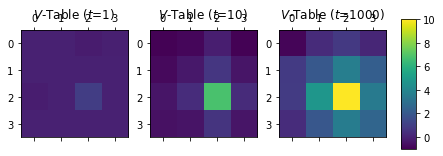

In [7]:
m = Maze()
a = VAgent(alpha=0.1)

fig, axs = plt.subplots(1,3, figsize=(7,3))

# Because the agent moves at random, the following instruction can take a variable amount of time to complete
run_trials(m, a, 1)  
a.visualizeV(axs[0])
axs[0].set_title(r"$V$-Table ($t$=1)")

run_trials(m, a, 10)
a.visualizeV(axs[1])
axs[1].set_title(r"$V$-Table ($t$=10)")

run_trials(m, a, 1000)
im = a.visualizeV(axs[2])
axs[2].set_title(r"$V$-Table ($t$=1000)")

#fig.colorbar(im, cax=cbar_ax)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.2, 0.03, 0.6])
fig.colorbar(im, cax=cbar_ax)
plt.savefig("vtable_maze.png")

## Creating a $Q$-Agent
Now we will create a $Q$-learning agent that interacts with the ``` Maze``` world. The $Q$-table should contain $16 \times 4 = 64$ different state-action pairs; rather than filling it up right away, we will fill it up as we encounter new state-action pairs, assuming that any previously unencountered state has a value of $Q = 0$ 

In [40]:
import random
import numpy as np

class QAgent():
    def __init__(self, actions=Maze.ACTIONS, epsilon=0.1, 
                 alpha=0.1, gamma=0.9, method="Q-learning"):
        """Creates a Q-agent"""
        self.Q = {}    ## Initial dictionary of (s, a) pairs. At the beginning, it's emtpy.

        self.epsilon = epsilon     # Epsilon for e-greey policy
        self.alpha = alpha         # Learning rate
        self.gamma = gamma         # Temporal discounting
        self.actions = actions     # Set of possible actions (provide those of Maze.ACTIONS)
        self.method = method
        
    def policy(self, state):
        """Selects an action with a epsilon-greedy policy"""
        if random.random() < self.epsilon:
            action = random.choice(self.actions)
        else:
            q = [self.Q[(state, a)] if (state, a) in self.Q.keys() else 0.0 for a in self.actions]
            maxQ = max(q)
            count = q.count(maxQ)
            if count > 1:
                best = [i for i in range(len(self.actions)) if q[i] == maxQ]
                i = random.choice(best)
            else:
                i = q.index(maxQ)

            action = self.actions[i]
        return action

    
    def q_learning(self, state1, action1, reward1, state2):
        """Updates the Q-values when given an (s,a) pair, the reward value and a new state"""
        g = self.gamma
        a = self.alpha
        
        q1 = 0.0
        
        if (state1, action1) in self.Q.keys():
            q1 = self.Q[(state1, action1)]
        
        max_q2 = max([self.Q[(state2, a)] if (state2, a) in self.Q.keys() else 0.0 for a in self.actions])
        
        rpe = reward1 + g * max_q2 - q1
        q1 += a * rpe
        self.Q[(state1, action1)] = q1
        
        
    def sarsa(self, state1, action1, reward1, state2, action2):
        """Updates the Q-values when given an (s,a) pair, the reward value and a new state"""
        g = self.gamma
        a = self.alpha
        
        q1 = 0.0
        q2 = 0.0
        
        if (state1, action1) in self.Q.keys():
            q1 = self.Q[(state1, action1)]
        
        if (state2, action2) in self.Q.keys():
            q2 = self.Q[(state2, action2)]
        
        rpe = reward1 + g * q2 - q1
        q1 += a * rpe
        self.Q[(state1, action1)] = q1
        
    
    def learn(self, state1, action1, reward1, state2, action2):
        "Generic method for learning actions"
        if self.method == "SARSA":
            self.sarsa(state1, action1, reward1, state2, action2)
        elif self.method == "Q-learning":
            self.q_learning(state1, action1, reward1, state2)
    

## Interactions between $Q$-Agent and Environment

For a $Q$-Agent to work properly, we need to redefine the `run_trial` function to handle to more complex expression that is needed for $Q$-learning and SARSA.  Because the agent actually _learns_ how to navigate the maze, we can also visualize the agent's preferred paths. 

In [81]:
def rl_loop(environment, agent):
    """A trial ends when the agent gets a reward. The history is returned"""
    state1  = environment.state
    reward1 = environment.grid[state1[0], state1[1]]
    
    action1 = agent.policy(state1)
    
    history = []
    state2  = ""
    
    while state2 != None:
        # Perceive the next step 
        state2, reward2 = environment.transition(action1)
        
        # Save the states visited
        history.append(state1)
        
        # Decide the next action and complete the loop
        action2 = agent.policy(state2)
        
        # Update the Q-values for state1, action1
        agent.learn(state1, action1, reward1, state2, action2)
        
        state1 = state2
        reward1 = reward2
        action1 = action2
        
    return history


def visualizeQ(agent):
    """Visualizes the Q tables, one per action"""
    fig, axs = plt.subplots(2, 2, figsize=(5,5))
    i = 0
    for a in agent.actions:
        # Create the corresponding state table
        mat = np.zeros((4,4))
        states = [x for x in agent.Q.keys() if x[1] == a]
            
        for s in states:
            x, y = s[0]
            mat[x, y] = agent.Q[s]
            
        # Show the Q-table as a heatmap
        im = axs.flat[i].matshow(mat, interpolation = "none", vmin=-1, vmax=10, 
                                 cmap='viridis')
        axs.flat[i].grid(color='w', linestyle='-', linewidth=2, which="minor")
        axs.flat[i].set_title(r"$Q$ values for '%s'" % a.upper(), pad=20)
        i += 1
        
    fig.subplots_adjust(right=0.85, hspace=0.5)
    cbar_ax = fig.add_axes([0.88, 0.2, 0.03, 0.6])
    fig.colorbar(im, cax=cbar_ax)
    #fig.tight_layout()
            

def visualize_history(history, title="Preferred Path"):
    "Visualizes the number of times each cell in the Maze has been transversed"
    mat = np.zeros((4,4))            
    for s in history:
        x, y = s
        mat[x, y] += 1
    
    mat /= np.max(mat)
    #mat *= 5  # min number of moves
    
    plt.matshow(mat, interpolation = "none", vmin=0, vmax=1, 
                cmap='Reds')
    
    plt.grid(color='w', linestyle='-', linewidth=1, which="minor")
    plt.title(title)
    plt.show()

## Testing the agent

Here a few tests.

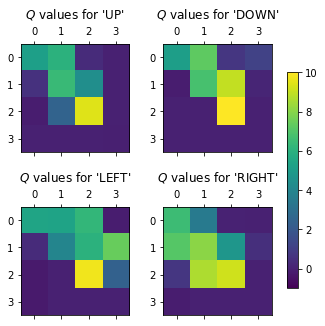

In [82]:
m = Maze()
a = QAgent(epsilon = 0.1)
run_trials(m, a, 1000)
visualizeQ(a)
plt.savefig("qtable.png")

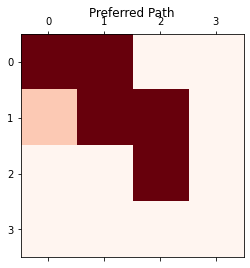

In [86]:
h = run_trials(m, a, 10)
visualize_history(h)

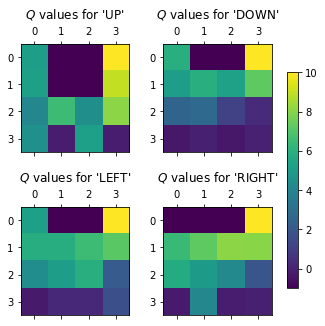

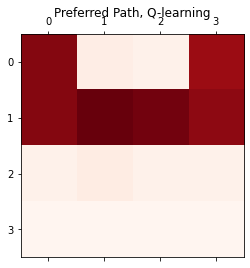

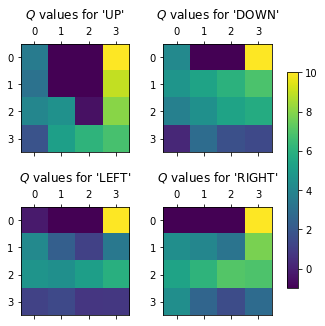

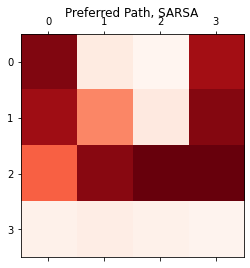

In [87]:
m = Maze("grid2.txt")
a1 = QAgent(epsilon = 0.1, method = "Q-learning")
a2 = QAgent(epsilon = 0.1, method = "SARSA")

run_trials(m, a1, 5000)
visualizeQ(a1)
h1 = run_trials(m, a1, 100)
visualize_history(h1, title = "Preferred Path, Q-learning")

run_trials(m, a2, 5000)
visualizeQ(a2)
h2 = run_trials(m, a2, 100)
visualize_history(h2, title = "Preferred Path, SARSA")

## How are the $Q$ values changing?

In [13]:
def run_trials_for_altair(environment, agent, n, collect=True):
    """Runs N trials"""
    state_action = {} 
    # init all state_actions
    for i in range(4):
        for j in range(4):
            for direction in ['down', 'right', 'up', 'left']:
                state_action[str(((i, j), direction))] = [0] 

    for j in range(n):
        run_trial(environment, agent)
        all_keys = set(state_action.keys())
        # keys with new values
        for key, val in agent.Q.items():
            state_action[str(key)].append(val)
            all_keys.remove(str(key))
        # keys without new values
        for key in all_keys:
            state_action[str(key)].append(state_action[str(key)][-1])
        environment.state = Maze.INITIAL_STATE
        
    import pandas as pd
    location = []
    run = []
    q_value = []
    for loc in state_action.keys():
        for i in range(len(state_action[loc])):
            location.append(loc)
            run.append(i)
            q_value.append(state_action[loc][i])
    df = pd.DataFrame({"location":location, "run":run, "q_value":q_value})
    return df    

In [14]:
m = Maze()
a = Agent()
df = run_trials_for_altair(m, a, 100)

NameError: name 'Agent' is not defined

In [ ]:
import altair as alt

slider = alt.binding_range(min=1, max=100, step=1)
select_run = alt.selection_single(name="iteration", fields=['run'], bind=slider)
alt.data_transformers.enable('default', max_rows=None)
alt.Chart(df).mark_bar().encode(
    x='location:N',
    y=alt.Y('q_value:Q', scale=alt.Scale(domain=(0, 11))),
).add_selection(
    select_run
).transform_filter(
    select_run
)

In [80]:
k = Maze("grid2.txt")
m = k.grid
np.min(m)

-100.0